In [94]:
import glob
import torch
import os
import torchaudio
import soundfile as sf
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from torch import Tensor
from pathlib import Path
from typing import Dict, List
from torchinfo import summary

plt.style.use('ggplot')

## Model 

In [95]:
drumkit_file = "../models/drumkit_v1.ts"

model = torch.jit.load(drumkit_file)
model.eval()
summary(model)

Layer (type:depth-idx)                                                      Param #
TraceModel                                                                  --
├─Resampling: 1-1                                                           --
│    └─Identity: 2-1                                                        --
│    └─Identity: 2-2                                                        --
├─CachedPQMF: 1-2                                                           --
│    └─CachedConv1d: 2-3                                                    4,112
│    │    └─CachedPadding1d: 3-1                                            --
│    │    └─CachedPadding1d: 3-2                                            --
│    └─CachedConv1d: 2-4                                                    4,352
│    │    └─CachedPadding1d: 3-3                                            --
│    │    └─CachedPadding1d: 3-4                                            --
├─Encoder: 1-3                           

In [96]:
print(model.state_dict().keys())
print(f"Latent size: {model.latent_size}")
print(f"Latent mean: {model.latent_mean.shape}")
print(f"Latent PCA shape: {model.latent_pca.shape}")
print(f"Model cropped size: {model.cropped_latent_size}")

odict_keys(['latent_pca', 'latent_mean', 'latent_size', 'sampling_rate', 'max_batch_size', 'encode_params', 'decode_params', 'forward_params', 'pqmf.hk', 'pqmf.h', 'pqmf.forward_conv.weight', 'pqmf.forward_conv.cache.pad', 'pqmf.forward_conv.downsampling_delay.pad', 'pqmf.inverse_conv.weight', 'pqmf.inverse_conv.cache.pad', 'pqmf.inverse_conv.downsampling_delay.pad', 'encoder.net.0.weight', 'encoder.net.0.bias', 'encoder.net.0.cache.pad', 'encoder.net.0.downsampling_delay.pad', 'encoder.net.1.weight', 'encoder.net.1.bias', 'encoder.net.1.running_mean', 'encoder.net.1.running_var', 'encoder.net.1.num_batches_tracked', 'encoder.net.3.weight', 'encoder.net.3.bias', 'encoder.net.3.cache.pad', 'encoder.net.3.downsampling_delay.pad', 'encoder.net.4.weight', 'encoder.net.4.bias', 'encoder.net.4.running_mean', 'encoder.net.4.running_var', 'encoder.net.4.num_batches_tracked', 'encoder.net.6.weight', 'encoder.net.6.bias', 'encoder.net.6.cache.pad', 'encoder.net.6.downsampling_delay.pad', 'encode

## Data

In [97]:
folder_path = "../data/finger_tapping/"
wav_files = []

for root, dirs, files in os.walk(folder_path):
    wav_files.extend(glob.glob(os.path.join(root, "*.wav")))
    wav_files.sort()
print(f"Found {len(wav_files)} wav files")

# Find the shortest WAV file
shortest_file = None
min_length = float('inf')

for wav_file in wav_files:
    waveform, sample_rate = sf.read(wav_file)
    if len(waveform) < min_length:
        min_length = len(waveform)
        shortest_file = wav_file

print(f"The shortest file is {shortest_file} with a length of {min_length} samples.")

Found 201 wav files
The shortest file is ../data/finger_tapping/onset_113.wav with a length of 2559 samples.


## Encode

In [98]:
# Create embeddings for all WAV files
embeddings = []

for file in wav_files:
    input_tensor, sample_rate = torchaudio.load(file) 
    # print(f"Loaded {file} with sample rate {sample_rate} and shape {input_tensor.shape}")
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor[:, :, :min_length]
    # print(f"Input tensor shape: {input_tensor.shape}")
    
    with torch.no_grad():
        z = model.encode(input_tensor)
        embeddings.append(z)

# embeddings shape: [1, 8, 2]
print(f"Created {len(embeddings)} embeddings")
print(f"Embedding shape: {embeddings[0].shape}")

Created 201 embeddings
Embedding shape: torch.Size([1, 8, 2])


In [99]:
# Create a list of dictionaries with the file name and embedding

embedding_data = []

for file, embedding in zip(wav_files, embeddings):
    data_point = {'file_name': file, 'embedding': embedding}
    embedding_data.append(data_point)

# Access the file name and embedding using the index, e.g. a random index
random_idx = np.random.randint(0, len(embedding_data))
print(f"Random index: {random_idx}")
data_point = embedding_data[random_idx]
file_name = data_point['file_name']
embedding = data_point['embedding']
print(f"File Name: {file_name}, Embedding Shape: {embedding.shape}")

Random index: 178
File Name: ../data/finger_tapping/onset_79.wav, Embedding Shape: torch.Size([1, 8, 2])


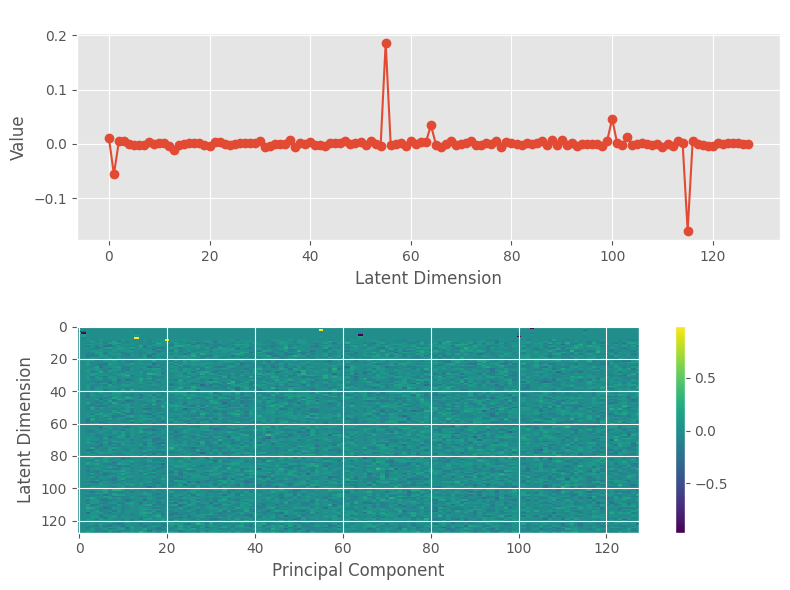

In [100]:
# Extract parameters from the state_dict
latent_mean = model.state_dict()['latent_mean'].numpy()
latent_pca = model.state_dict()['latent_pca'].numpy()

# Plot latent_mean
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(latent_mean, marker='o')
plt.title('Latent Mean')
plt.xlabel('Latent Dimension')
plt.ylabel('Value')

# Plot latent_pca
plt.subplot(2, 1, 2)
plt.imshow(latent_pca, cmap='viridis', aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Latent PCA')
plt.xlabel('Principal Component')
plt.ylabel('Latent Dimension')

plt.tight_layout()
plt.show()

## Visualize Embeddings with t-SNE

In [101]:
# Concatenate embeddings into a single array
embeddings_array = np.concatenate(embeddings, axis=1).squeeze()

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_array)

# Create a DataFrame for Plotly
tsne_df = pd.DataFrame(data={'Dimension 1': embeddings_tsne[:, 0], 'Dimension 2': embeddings_tsne[:, 1]})

# Plot the interactive t-SNE representation
fig = px.scatter(tsne_df, x='Dimension 1', y='Dimension 2', title='t-SNE Representation of Embeddings with coordinates')
fig.update_layout(title='Interactive t-SNE Representation of Embeddings')
fig.show()

In [102]:
# Flatten the embeddings into a 1D array for box plot
flat_embeddings = [emb.flatten() for emb in embeddings]
flat_embeddings_df = pd.DataFrame(flat_embeddings, columns=[f'Dimension_{i+1}' for i in range(len(flat_embeddings[0]))])

# Create a box plot
fig = px.box(flat_embeddings_df, title='Box Plot of Embeddings Dimensions')
fig.update_layout(title='Box Plot of Embeddings Dimensions')
fig.show()

In [103]:
# Choose two points for interpolation
point1 = embeddings_tsne[0]
point2 = embeddings_tsne[-1]

# Generate interpolated points
num_interp_points = 5
interp_points = np.linspace(0, 1, num_interp_points)
interpolated_tsne_points = np.array([np.interp(interp_points, [0, 1], [point1[i], point2[i]]) for i in range(2)]).T

# Create a DataFrame for Plotly
interp_df = pd.DataFrame(data={'Dimension 1': interpolated_tsne_points[:, 0], 'Dimension 2': interpolated_tsne_points[:, 1]})

# Plot the interactive t-SNE representation with interpolated points
fig = px.scatter(tsne_df, x='Dimension 1', y='Dimension 2', title='Interactive t-SNE Representation of Embeddings with Interpolation')
fig.add_trace(go.Scatter(x=interp_df['Dimension 1'], y=interp_df['Dimension 2'], mode='markers+lines', name='Interpolated Points'))
fig.update_layout(title='Interactive t-SNE Representation of Embeddings with Interpolation')
fig.show()

In [104]:
print(interpolated_tsne_points)

[[ 19.73012161  27.79846382]
 [  7.17505169  21.62966752]
 [ -5.38001823  15.46087122]
 [-17.93508816   9.29207492]
 [-30.49015808   3.12327862]]
